In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf 
import pandas_datareader as pdr
from simulation.simulation import simulate_normal_returns, alpha_stable_sampler_QMC

%load_ext autoreload
%autoreload 2

In [2]:
# TO DO : i) entrainer le LSTM ii) calculer les poids optimaux et ploter

## 1) Loading market data 

In [3]:
tickers_cac40 = [
    "ACC.PA",  # Accor
    "AI.PA",   # Air Liquide
    "AIR.PA",  # Airbus Group
    "MT.AS",   # ArcelorMittal
    "CS.PA",   # AXA
    "BNP.PA",  # BNP Paribas
    "EN.PA",   # Bouygues
    "CAP.PA",  # Capgemini
    "CA.PA",   # Carrefour
    "ACA.PA",  # Crédit Agricole
    "BN.PA",   # Danone
    "DSY.PA",  # Dassault Systèmes
    "EDEN.PA", # Edenred
    "ENGI.PA", # Engie
    "EL.PA",   # EssilorLuxottica
    "ERF.PA",  # Eurofins Scientific
    "RMS.PA",  # Hermès International
    "KER.PA",  # Kering
    "LR.PA",   # Legrand
    "OR.PA",   # L'Oréal
    "MC.PA",   # LVMH
    "ML.PA",   # Michelin
    "ORA.PA",  # Orange
    "RI.PA",   # Pernod Ricard
    "PUB.PA",  # Publicis Groupe
    "RNO.PA",  # Renault
    "SAF.PA",  # Safran
    "SGO.PA",  # Saint-Gobain
    "SAN.PA",  # Sanofi
    "SU.PA",   # Schneider Electric
    "GLE.PA",  # Société Générale
    "STLA.PA", # Stellantis
    "STM.PA",  # STMicroelectronics
    "TEP.PA",  # Téléperformance
    "HO.PA",   # Thales
    "TTE.PA",  # TotalEnergies
    "URW.PA",  # Unibail-Rodamco-Westfield
    "VIE.PA",  # Veolia Environnement
    "DG.PA",   # Vinci
    "VIV.PA"   # Vivendi
]

tickers_cac40_dict = {
    "ACC.PA": "Accor",
    "AI.PA": "Air Liquide",
    "AIR.PA": "Airbus Group",
    "MT.AS": "ArcelorMittal",
    "CS.PA": "AXA",
    "BNP.PA": "BNP Paribas",
    "EN.PA": "Bouygues",
    "CAP.PA": "Capgemini",
    "CA.PA": "Carrefour",
    "ACA.PA": "Crédit Agricole",
    "BN.PA": "Danone",
    "DSY.PA": "Dassault Systèmes",
    "EDEN.PA": "Edenred",
    "ENGI.PA": "Engie",
    "EL.PA": "EssilorLuxottica",
    "ERF.PA": "Eurofins Scientific",
    "RMS.PA": "Hermès International",
    "KER.PA": "Kering",
    "LR.PA": "Legrand",
    "OR.PA": "L'Oréal",
    "MC.PA": "LVMH",
    "ML.PA": "Michelin",
    "ORA.PA": "Orange",
    "RI.PA": "Pernod Ricard",
    "PUB.PA": "Publicis Groupe",
    "RNO.PA": "Renault",
    "SAF.PA": "Safran",
    "SGO.PA": "Saint-Gobain",
    "SAN.PA": "Sanofi",
    "SU.PA": "Schneider Electric",
    "GLE.PA": "Société Générale",
    "STLA.PA": "Stellantis",
    "STM.PA": "STMicroelectronics",
    "TEP.PA": "Téléperformance",
    "HO.PA": "Thales",
    "TTE.PA": "TotalEnergies",
    "URW.PA": "Unibail-Rodamco-Westfield",
    "VIE.PA": "Veolia Environnement",
    "DG.PA": "Vinci",
    "VIV.PA": "Vivendi"
}

In [4]:
selected_tickers = [tickers_cac40[i] for i in [1,4,6,8]]
selected_tickers_names = [tickers_cac40_dict[key] for key in selected_tickers]
start_date = '2010-01-01'
interval = '1d'

market_data = yf.download(selected_tickers, start='2010-01-01', interval=interval)
market_data.index = market_data.index.tz_localize(None).floor('D')
# Pk utiliser la date comme ça sans jour?
#market_data["Date"] = market_data["Date"].dt.strftime('%Y/%m')
market_data = market_data[["Adj Close"]]
print(market_data.shape)
market_data.head()

[*********************100%***********************]  4 of 4 completed

(3823, 4)


Price       Adj Close                                
Ticker          AI.PA      CA.PA     CS.PA      EN.PA
Date                                                 
2010-01-04  30.840050  21.601978  7.704947  16.893999
2010-01-05  30.223248  22.113441  7.833363  17.101635
2010-01-06  30.037119  21.951424  7.913622  17.192907
2010-01-07  30.000626  21.703636  7.824189  16.957890
2010-01-08  30.095512  21.916479  7.849414  16.964735

## 2) Retrieving useful statistics

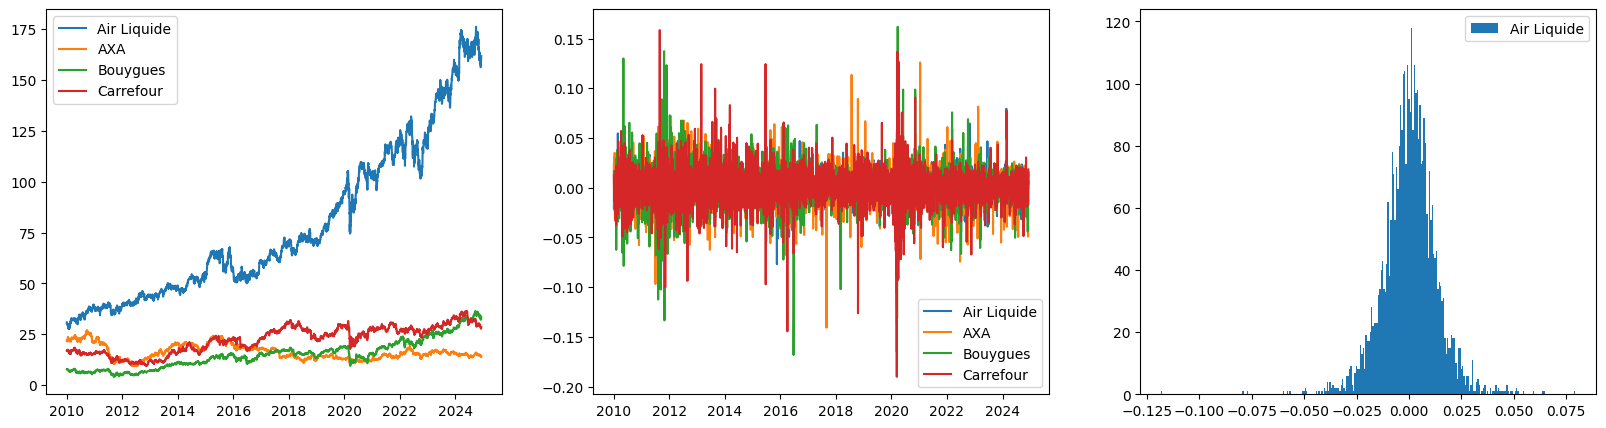

In [5]:
market_returns = np.log(market_data['Adj Close']) - np.log(market_data['Adj Close'].shift(1))
market_returns.dropna(inplace=True)
mean_returns = market_returns.mean()
mean_returns_value = mean_returns.values
cov_market = market_returns.cov() 
cov_market_values = cov_market.values

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(market_data['Adj Close'], label=selected_tickers_names)
plt.legend()
plt.subplot(132)
plt.plot(market_returns, label=selected_tickers_names)
plt.legend()
plt.subplot(133)
i = 0 
plt.hist(market_returns.iloc[:,i], label=selected_tickers_names[i], bins=300)
plt.legend()
plt.show()

In [6]:
market_returns

Ticker,AI.PA,CA.PA,CS.PA,EN.PA
Date,,,,
2010-01-05,-0.020203,0.023401,0.016529,0.012216
2010-01-06,-0.006178,-0.007354,0.010194,0.005323
2010-01-07,-0.001216,-0.011352,-0.011366,-0.013764
2010-01-08,0.003158,0.009759,0.003219,0.000404
2010-01-11,-0.006204,-0.015042,-0.005272,0.009771
...,...,...,...,...
2024-11-29,0.006378,-0.010706,0.014661,0.001421
2024-12-02,0.014267,-0.049103,-0.013431,-0.017554
2024-12-03,0.003004,0.010881,-0.007713,0.004327


### 3) Simulating returns

In [7]:
np.random.seed(42)

In [8]:
# N correspond au nombre de timesteps (on est dans l'unité de la data originale, donc jour en l'occurence cf variable "interval" plus haut)
# La 2e dimension du tenseur donne les différentes simulations 
# la 3e au nombre d'assets

#N = le nbre de timsteps
N = market_returns.shape[0]
simulated_returns = simulate_normal_returns(mu=mean_returns_value, cov=cov_market_values, N= N, n_simul=100)
simulated_returns.shape

(3822, 100, 4)

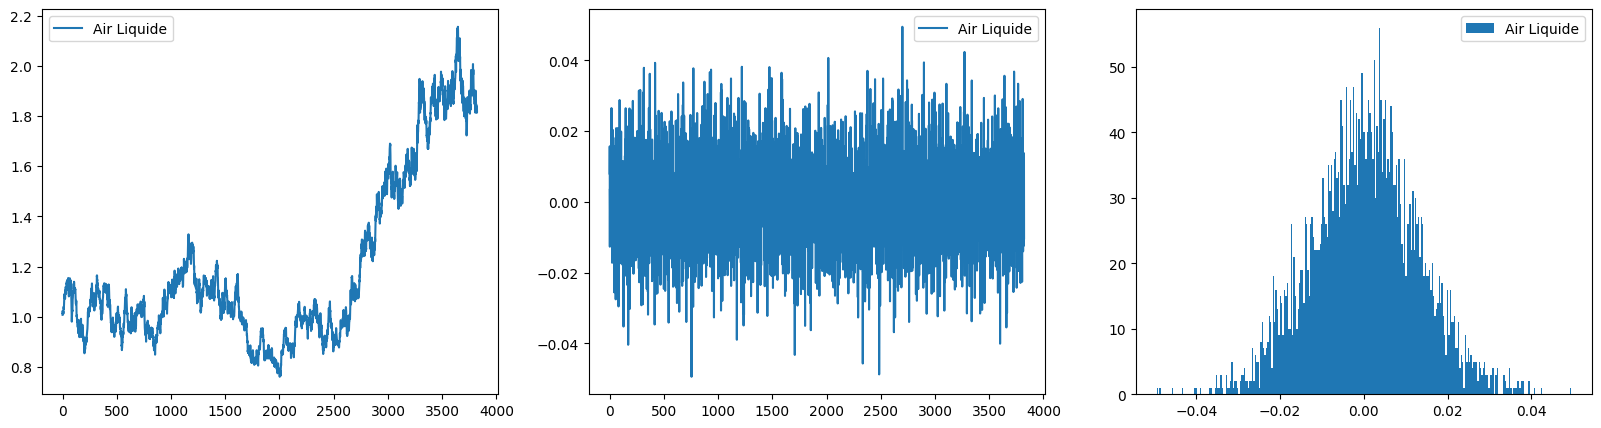

In [9]:
i = 0 
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(np.cumprod(1 + simulated_returns[:, i, 0]), label=selected_tickers_names[i])
plt.legend()
plt.subplot(132)
plt.plot(simulated_returns[:, i, 0], label=selected_tickers_names[i])
plt.legend()
plt.subplot(133)
i = 0 
plt.hist(simulated_returns[:, i, 0], label=selected_tickers_names[i], bins=300)
plt.legend()
plt.show()

## 3) Training the LSTM 

# Prblm : pk ça va pas jusqu'à la dernière date ?  fcts get training et test periods à modifier pour prendre toute la période peut etre

In [17]:
dates = market_data.index[:simulated_returns.shape[0]]  

single_simulation = simulated_returns[:, 0, :]

simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
simulation_df.index = dates[:len(simulation_df)]  

In [28]:
from models.base import NN_Sharpe
import torch 

input_size=4
hidden_size=64  
output_size=4  
num_layers=1  
model_name='GRU'

model = NN_Sharpe(input_size, hidden_size, output_size, num_layers, model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.2)


In [24]:
from models.utils import training_with_model

results = training_with_model(
    data_used=simulation_df.dropna(),  
    model=model, 
    optimizer=optimizer, 
    initial_train_years=4,  
    retrain_years=2,  
    rolling_window=50, 
    shuffle=False,  
    epoch=50,
    batch_size=64,  
    overlap=False 
)

training from 2010-01-04 00:00:00 to 2013-12-10 00:00:00
invest from 2013-12-10 00:00:00 to 2015-12-01 00:00:00
torch.Size([20, 50, 4])
epoch 0, loss = -0.0064202831126749516
epoch 1, loss = -0.006422729697078466
epoch 2, loss = -0.006425175815820694
epoch 3, loss = -0.0064276354387402534
epoch 4, loss = -0.006430129054933786
epoch 5, loss = -0.006432634778320789
epoch 6, loss = -0.0064351512119174
epoch 7, loss = -0.0064377011731266975
epoch 8, loss = -0.006440256722271442
epoch 9, loss = -0.006442832760512829
epoch 10, loss = -0.0064454274252057076
epoch 11, loss = -0.006448023021221161
epoch 12, loss = -0.006450636778026819
epoch 13, loss = -0.006453250534832478
epoch 14, loss = -0.006455892231315374
epoch 15, loss = -0.006458534859120846
epoch 16, loss = -0.00646119425073266
epoch 17, loss = -0.006463864352554083
epoch 18, loss = -0.006466538645327091
epoch 19, loss = -0.006469234824180603
epoch 20, loss = -0.006471923552453518
epoch 21, loss = -0.006474635098129511
epoch 22, loss 

In [26]:
results.dropna(how='any')

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf
Date,,,,,
2013-12-10,0.231747,0.287888,0.232536,0.247830,-0.003730
2013-12-11,0.231596,0.287979,0.232564,0.247861,0.012651
2013-12-12,0.231665,0.288119,0.232504,0.247712,-0.018214
2013-12-13,0.231722,0.287798,0.232626,0.247854,-0.000877
2013-12-16,0.231893,0.287794,0.232573,0.247740,-0.019751
...,...,...,...,...,...
2023-10-05,0.235775,0.278154,0.240276,0.245795,0.012924
2023-10-06,0.235895,0.278352,0.240109,0.245644,0.015922
2023-10-09,0.235940,0.278490,0.239980,0.245590,0.013870


In [29]:
from models.base import NN_Sharpe
from models.utils import training

num_simulations = simulated_returns.shape[1]  
dates = market_data.index[:simulated_returns.shape[0]]  

# Itérer sur chaque simulation
for i in range(num_simulations):
    # Extraire la simulation i
    single_simulation = simulated_returns[:, i, :]
    
    simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
    simulation_df.index = dates[:len(simulation_df)]  
    
    print(f"Training on simulation {i + 1}/{num_simulations}...")

    # Entraîner le modèle sur cette simulation
    simulation_result = training_with_model(
        data_used=simulation_df.dropna(),  
        model=model, 
        optimizer=optimizer, 
        initial_train_years=4,  
        retrain_years=2,  
        rolling_window=50, 
        shuffle=False,  
        epoch=50,
        batch_size=64,  
        overlap=False 
    )

    #taking the final results 
    if(i==num_simulations-1):
        results = simulation_result
    



Training on simulation 1/100...
training from 2010-01-04 00:00:00 to 2013-12-10 00:00:00
invest from 2013-12-10 00:00:00 to 2015-12-01 00:00:00
torch.Size([20, 50, 4])
epoch 0, loss = -0.00701740849763155
epoch 1, loss = -0.007020821329206228
epoch 2, loss = -0.007024222053587437
epoch 3, loss = -0.0070276157930493355
epoch 4, loss = -0.007031007669866085
epoch 5, loss = -0.007034385111182928
epoch 6, loss = -0.007037746254354715
epoch 7, loss = -0.007041092962026596
epoch 8, loss = -0.0070444317534565926
epoch 9, loss = -0.007047770079225302
epoch 10, loss = -0.007051094435155392
epoch 11, loss = -0.007054413668811321
epoch 12, loss = -0.0070577347651124
epoch 13, loss = -0.007061034440994263
epoch 14, loss = -0.007064336445182562
epoch 15, loss = -0.007067637052386999
epoch 16, loss = -0.007070927415043116
epoch 17, loss = -0.007074221968650818
epoch 18, loss = -0.00707751139998436
epoch 19, loss = -0.007080801762640476
epoch 20, loss = -0.007084081880748272
epoch 21, loss = -0.00708

In [31]:
results = results.dropna(how='any')
results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf
Date,,,,,
2013-12-10,0.256930,0.246789,0.250330,0.24595,-0.019203
2013-12-11,0.256930,0.246789,0.250330,0.24595,0.005947
2013-12-12,0.256930,0.246789,0.250330,0.24595,0.016568
2013-12-13,0.256930,0.246789,0.250330,0.24595,0.005539
2013-12-16,0.256930,0.246789,0.250330,0.24595,-0.028758
...,...,...,...,...,...
2023-10-05,0.254685,0.247509,0.253166,0.24464,0.003525
2023-10-06,0.254685,0.247509,0.253166,0.24464,-0.000607
2023-10-09,0.254685,0.247509,0.253166,0.24464,-0.008293


In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np


paper_results = results.copy()

paper_results['cumulative_return'] = (1 + paper_results['return_pf']).cumprod()



In [41]:
paper_results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf,cumulative_return
Date,,,,,,
2013-12-10,0.256930,0.246789,0.250330,0.24595,-0.019203,0.980797
2013-12-11,0.256930,0.246789,0.250330,0.24595,0.005947,0.986630
2013-12-12,0.256930,0.246789,0.250330,0.24595,0.016568,1.002976
2013-12-13,0.256930,0.246789,0.250330,0.24595,0.005539,1.008532
2013-12-16,0.256930,0.246789,0.250330,0.24595,-0.028758,0.979528
...,...,...,...,...,...,...
2023-10-05,0.254685,0.247509,0.253166,0.24464,0.003525,1.113874
2023-10-06,0.254685,0.247509,0.253166,0.24464,-0.000607,1.113198
2023-10-09,0.254685,0.247509,0.253166,0.24464,-0.008293,1.103967


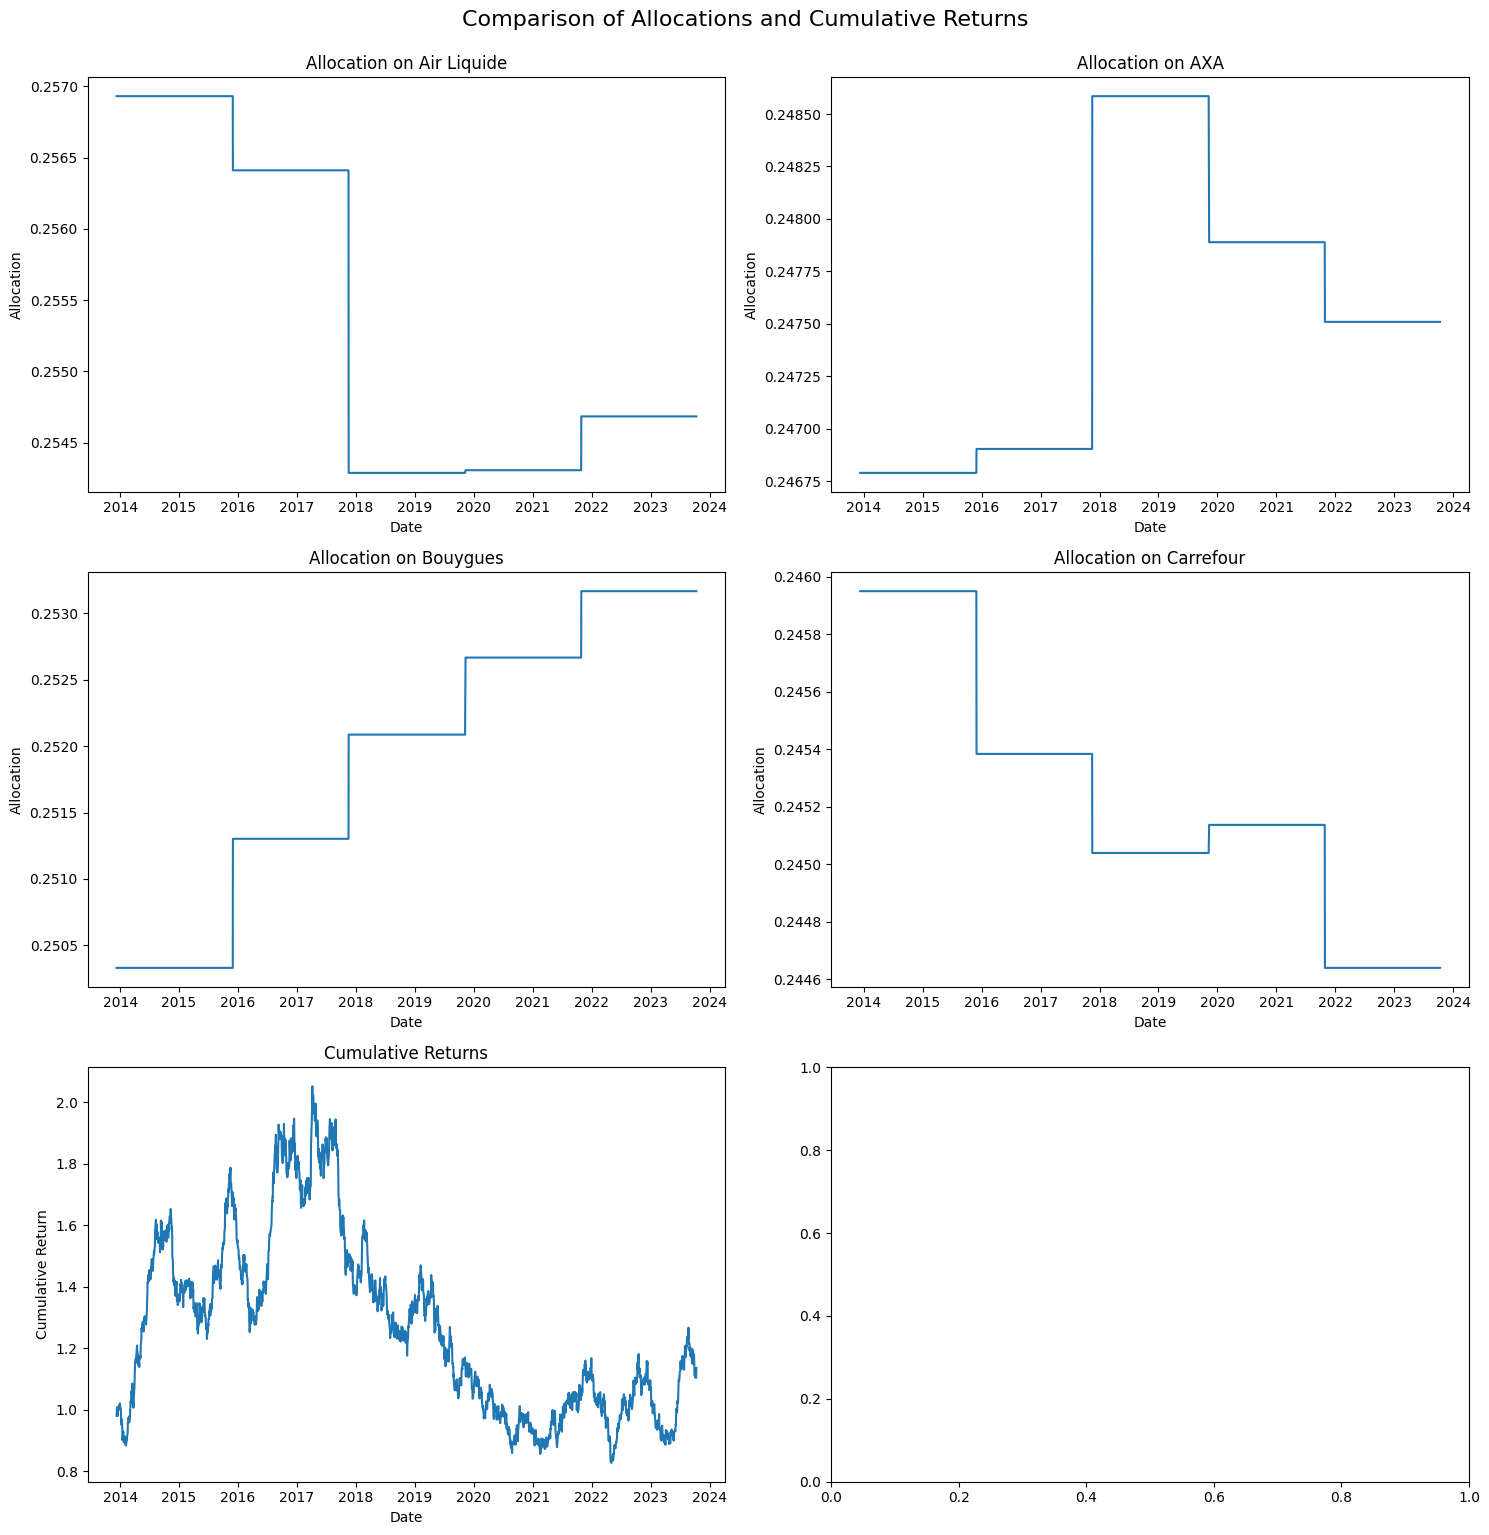

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust subplot layout to have 5 subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Flatten the axes to make it easier to iterate over
axs = axs.flatten()[:5]  # Only use the first 5 subplots

# Titles for the 5 subplots
subplot_titles = [
    "Allocation on Air Liquide", "Allocation on AXA",
    "Allocation on Bouygues", "Allocation on Carrefour",
    "Cumulative Returns"
]

# Set titles for each subplot
for i, ax in enumerate(axs):
    ax.set_title(subplot_titles[i])

# Allocation columns dictionary
allocations = {    
    'Air Liquide_alloc': 0,
    'AXA_alloc': 1,
    'Bouygues_alloc': 2,
    'Carrefour_alloc': 3
}

# Plot allocation for each asset
for alloc, ax_index in allocations.items():
    ax = axs[ax_index]
    if alloc in paper_results.columns:
        ax.plot(
            paper_results.index,
            paper_results[alloc],
            label=alloc,
        )
    ax.set_xlabel('Date')
    ax.set_ylabel('Allocation')

# Plot cumulative returns in the last subplot
ax = axs[4]
if 'cumulative_return' in paper_results.columns:
    cumulative_return = paper_results['cumulative_return']
    ax.plot(
        paper_results.index,
        cumulative_return,
        label='Cumulative Return',
    )
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')

# Adjust layout and title
plt.tight_layout()
plt.suptitle("Comparison of Allocations and Cumulative Returns", fontsize=16, y=1.02)
plt.show()
